#### Contest entry by Wouter Kimman 


Strategy: 
----------------------------------------------
stacking and optimized selective use of the training data

In [1]:
from numpy.fft import rfft
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import pandas as pd
import timeit
from sqlalchemy.sql import text
from sklearn import tree
#from sklearn.model_selection import LeavePGroupsOut
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
#import sherlock.filesystem as sfs
#import sherlock.database as sdb
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import collections

In [2]:

def permute_facies_nr(predicted_super, predicted0, faciesnr):
    predicted=predicted0.copy()
    N=len(predicted)
    for ii in range(N):
        if predicted_super[ii]==1:
            predicted[ii]=faciesnr  
    return predicted

In [3]:
def binarify(dataset0, facies_nr):
    dataset=dataset0.copy()
    mask=dataset != facies_nr
    dataset[mask]=0
    mask=dataset == facies_nr
    dataset[mask]=1    
    return dataset

In [4]:

def make_balanced_binary(df_in, faciesnr, factor):
    df=df_in.copy()
    y=df['Facies'].values
    y0=binarify(y, faciesnr)
    df['Facies']=y0

    df1=df[df['Facies']==1]
    X_part1=df1.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    y_part1=df1['Facies'].values
    N1=len(df1)

    df2=df[df['Facies']==0]
    X_part0=df2.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    y_part0=df2['Facies'].values
    N2=len(df2)
    print "ratio now:"
    print float(N2)/float(N1)
    ratio_to_keep=factor*float(N1)/float(N2)
    print "ratio after:"
    print float(N2)/(factor*float(N1))
    dum1, X_part2, dum2, y_part2 = train_test_split(X_part0, y_part0, test_size=ratio_to_keep, random_state=42)

    tmp=[X_part1, X_part2]  
    X = pd.concat(tmp, axis=0)
    y = np.concatenate((y_part1, y_part2))
    return X, y




In [5]:
# output f1
#def phaseI_model(correct_facies_labels, features_blind,regime_train, correctA, go_B, clf, pred_array, pred_blind):   
#    clf.fit(regime_train,correctA)     
#    predicted_B = clf.predict(go_B)
#    pred_array = np.vstack((predicted_B, pred_array))    
#    predicted_blind1 = clf.predict(features_blind)
#    out_f1=metrics.f1_score(correct_facies_labels, predicted_blind1, average = 'micro')
#    print "f1 score on the prediction of blind"
#    print out_f1
#    pred_blind = np.vstack((predicted_blind1, pred_blind))
#    return pred_array, pred_blind
#
#def phaseI_model_scaled(correct_facies_labels, features_blind,regime_train, correctA, go_B, clf, pred_array, pred_blind):   
#    regime_train=StandardScaler().fit_transform(regime_train)
#    go_B=StandardScaler().fit_transform(go_B)
#    features_blind=StandardScaler().fit_transform(features_blind)
#    clf.fit(regime_train,correctA)     
#    predicted_B = clf.predict(go_B)
#    pred_array = np.vstack((predicted_B, pred_array))    
#    predicted_blind1 = clf.predict(features_blind)
#    out_f1=metrics.f1_score(correct_facies_labels, predicted_blind1, average = 'micro')
#    print "f1 score on the prediction of blind"
#    print out_f1
#    pred_blind = np.vstack((predicted_blind1, pred_blind))
#    return pred_array, pred_blind

In [6]:
def phaseI_model(regime_train, correctA, go_B, clf, pred_array, pred_blind, features_blind):      
    clf.fit(regime_train,correctA)     
    predicted_B = clf.predict(go_B)
    pred_array = np.vstack((predicted_B, pred_array))   
    predicted_blind1 = clf.predict(features_blind)
    pred_blind = np.vstack((predicted_blind1, pred_blind))    
    return pred_array, pred_blind

def phaseI_model_scaled(regime_train, correctA, go_B, clf, pred_array, pred_blind, features_blind):   
    regime_train=StandardScaler().fit_transform(regime_train)
    go_B=StandardScaler().fit_transform(go_B)
    features_blind=StandardScaler().fit_transform(features_blind)
    clf.fit(regime_train,correctA)     
    predicted_B = clf.predict(go_B)
    pred_array = np.vstack((predicted_B, pred_array))
    predicted_blind1 = clf.predict(features_blind)
    pred_blind = np.vstack((predicted_blind1, pred_blind))
    return pred_array, pred_blind

In [7]:
def create_structure_for_regimes(df):
    allfeats=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
    data_all = []
    for feat in allfeats:
        dff=df.groupby('Well Name').describe(percentiles=[0.1, 0.25, .5, 0.75, 0.9]).reset_index().pivot(index='Well Name', values=feat, columns='level_1')
        dff = dff.drop(['count'], axis=1)
        cols=dff.columns
        cols_new=[]
        for ii in cols:
            strin=feat + "_" + str(ii)
            cols_new.append(strin)
        dff.columns=cols_new 
        dff1=dff.reset_index()
        if feat=='GR':
            data_all.append(dff1)
        else:
            data_all.append(dff1.iloc[:,1:])
    data_all = pd.concat(data_all,axis=1)
    return data_all 

**This is the only feature engineering used:**

In [8]:

def magic(df):
    df1=df.copy()
    b, a = signal.butter(2, 0.2, btype='high', analog=False)
    feats0=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
    #feats01=['GR','ILD_log10','DeltaPHI','PHIND']
    #feats01=['DeltaPHI']
    #feats01=['GR','DeltaPHI','PHIND']
    feats01=['GR',]
    feats02=['PHIND']
    #feats02=[]
    for ii in feats0:
        df1[ii]=df[ii]
        name1=ii + '_1'
        name2=ii + '_2'
        name3=ii + '_3'
        name4=ii + '_4'
        name5=ii + '_5'
        name6=ii + '_6'
        name7=ii + '_7'
        name8=ii + '_8'
        name9=ii + '_9'
        xx1 = list(df[ii])
        xx_mf= signal.medfilt(xx1,9)
        x_min1=np.roll(xx_mf, 1)
        x_min2=np.roll(xx_mf, -1)
        x_min3=np.roll(xx_mf, 3)
        x_min4=np.roll(xx_mf, 4)
        xx1a=xx1-np.mean(xx1)
        xx_fil = signal.filtfilt(b, a, xx1)        
        xx_grad=np.gradient(xx1a) 
        x_min5=np.roll(xx_grad, 3)
        #df1[name4]=xx_mf
        if ii in feats01: 
            df1[name1]=x_min3
            df1[name2]=xx_fil
            df1[name3]=xx_grad
            df1[name4]=xx_mf 
            df1[name5]=x_min1
            df1[name6]=x_min2
            df1[name7]=x_min4
            #df1[name8]=x_min5
            #df1[name9]=x_min2
        if ii in feats02:
            df1[name1]=x_min3
            df1[name2]=xx_fil
            df1[name3]=xx_grad
            #df1[name4]=xx_mf 
            df1[name5]=x_min1
            #df1[name6]=x_min2 
            #df1[name7]=x_min4
    return df1

        


        
        

In [9]:
#filename = 'training_data.csv'
filename = 'facies_vectors.csv'
training_data0 = pd.read_csv(filename)
filename = 'validation_data_nofacies.csv'
test_data = pd.read_csv(filename)


In [10]:
all_wells=training_data0['Well Name'].unique()
print all_wells

['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE'
 'NOLAN' 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']


In [11]:
# what to do with the naans
training_data1=training_data0.copy()
me_tot=training_data1['PE'].median()
print me_tot
for well in all_wells:
    df=training_data0[training_data0['Well Name'] == well] 
    print well
    print len(df)
    df0=df.dropna()
    #print len(df0)
    if len(df0) > 0:
        print "using median of local"
        me=df['PE'].median()
        df=df.fillna(value=me)
    else:
        print "using median of total"
        df=df.fillna(value=me_tot)
    training_data1[training_data0['Well Name'] == well] =df
    

print len(training_data1)
df0=training_data1.dropna()
print len(df0)

3.5515
SHRIMPLIN
471
using median of local
ALEXANDER D
466
using median of total
SHANKLE
449
using median of local
LUKE G U
461
using median of local
KIMZEY A
439
using median of total
CROSS H CATTLE
501
using median of local
NOLAN
415
using median of local
Recruit F9
80
using median of local
NEWBY
463
using median of local
CHURCHMAN BIBLE
404
using median of local
4149
4149


In [12]:
#remove outliers
df=training_data1.copy()
print len(df)
df0=df.dropna()
print len(df0)
df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
#df=pd.DataFrame(np.random.randn(20,3))
#df.iloc[3,2]=5
print len(df1)
df2=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
print len(df2)

4149
4149
4149
4143


In [13]:
df2a=df2[df2['Well Name'] != 'Recruit F9'] 

In [14]:
data_all=create_structure_for_regimes(df2a)
data_test=create_structure_for_regimes(test_data)

In [15]:
data_test

,Well Name,GR_10%,GR_25%,GR_50%,GR_75%,GR_90%,GR_max,GR_mean,GR_min,GR_std,...,NM_M_std,RELPOS_10%,RELPOS_25%,RELPOS_50%,RELPOS_75%,RELPOS_90%,RELPOS_max,RELPOS_mean,RELPOS_min,RELPOS_std
0,CRAWFORD,24.9075,41.1465,58.413,73.55225,84.7215,167.803,58.666020,16.197,26.033591,...,0.438386,0.1240,0.2775,0.537,0.7765,0.9145,1.0,0.52623,0.017,0.287468
1,STUART,24.1612,34.5620,57.851,72.50275,82.7020,220.413,56.819901,12.036,28.600303,...,0.483098,0.1436,0.3180,0.550,0.7795,0.9257,1.0,0.54300,0.013,0.279796


**kmeans clustering to find natural clusters:**

In [624]:

frames = [data_all, data_test]
X = pd.concat(frames)
X

,Well Name,GR_10%,GR_25%,GR_50%,GR_75%,GR_90%,GR_max,GR_mean,GR_min,GR_std,...,NM_M_std,RELPOS_10%,RELPOS_25%,RELPOS_50%,RELPOS_75%,RELPOS_90%,RELPOS_max,RELPOS_mean,RELPOS_min,RELPOS_std
0,ALEXANDER D,25.9700,44.8650,72.285,88.92750,100.7850,168.430,68.280236,13.340,28.635640,...,0.497648,0.1125,0.2670,0.518,0.76125,0.9105,1.0,0.515584,0.000,0.289040
1,CHURCHMAN BIBLE,33.6532,41.3755,59.203,74.31250,95.6691,222.500,63.683453,14.469,33.333992,...,0.448185,0.1265,0.2860,0.567,0.80000,0.9290,1.0,0.544317,0.011,0.293647
2,CROSS H CATTLE,50.4050,60.1980,73.595,84.81900,94.6482,184.021,72.423513,13.893,20.851035,...,0.458631,0.1066,0.2580,0.500,0.75000,0.9000,1.0,0.503288,0.013,0.288401
3,KIMZEY A,23.5474,34.8140,56.582,66.58800,73.8642,245.360,53.334339,10.149,24.761446,...,0.487142,0.1328,0.3040,0.548,0.78500,0.9202,1.0,0.539453,0.010,0.284105
4,LUKE G U,29.6800,48.4500,66.190,78.49000,87.3500,195.890,64.777223,13.530,27.427174,...,0.499410,0.1190,0.2630,0.522,0.76100,0.9120,1.0,0.514095,0.010,0.286902
5,NEWBY,28.4880,38.1100,60.330,71.44500,85.7180,305.870,60.733045,13.920,33.620632,...,0.486991,0.1234,0.2930,0.535,0.77150,0.9198,1.0,0.528138,0.010,0.285096
6,NOLAN,23.7500,43.3905,72.375,88.50000,102.5250,247.500,68.693940,13.250,32.730216,...,0.499834,0.1336,0.3070,0.577,0.79350,0.9206,1.0,0.549007,0.017,0.285563
7,SHANKLE,35.0760,54.9600,66.600,75.15000,83.1820,242.750,65.431180,18.400,25.696418,...,0.474493,0.1188,0.2580,0.500,0.74400,0.8952,1.0,0.503118,0.010,0.282082
8,SHRIMPLIN,28.6580,46.8300,69.300,85.85000,96.3580,274.000,68.169936,13.280,32.170245,...,0.500342,0.1110,0.2590,0.511,0.76500,0.9154,1.0,0.514399,0.010,0.290373
0,CRAWFORD,24.9075,41.1465,58.413,73.55225,84.7215,167.803,58.666020,16.197,26.033591,...,0.438386,0.1240,0.2775,0.537,0.77650,0.9145,1.0,0.526230,0.017,0.287468


In [626]:
X1 = X.drop(['Well Name'], axis=1)

In [630]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X1)
kmeans.labels_

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

In [1793]:
kmeans = KMeans(n_clusters=4).fit(X1)
kmeans.labels_

array([0, 2, 0, 3, 0, 1, 1, 2, 1, 0, 3], dtype=int32)

Through experimenting with the cluster size I've decided on 4 clusters.
This corresponds largely with the corresponding similarity in facies distribution

**CRAWFORD is most similar to ALEXANDER and LUKE**. This will called cluster 1. (The only ones with facies 1)

**STUART is most similar to KIMZEY and NOLAN** This will be called cluster 2


Collating the Data:
-----------------------------------------------------------
based on the regimes we determined 

In [16]:
# based on kmeans clustering
data=[]
df = training_data0[training_data0['Well Name'] == 'ALEXANDER D'] 
data.append(df)
df = training_data0[training_data0['Well Name'] == 'LUKE G U']  
data.append(df)
df = training_data0[training_data0['Well Name'] == 'CROSS H CATTLE']  
data.append(df)
Regime_1 = pd.concat(data, axis=0)
print len(Regime_1)

data=[]
df = training_data0[training_data0['Well Name'] == 'KIMZEY A']  
data.append(df)
df = training_data0[training_data0['Well Name'] == 'NOLAN']
data.append(df)
df = training_data0[training_data0['Well Name'] == 'CHURCHMAN BIBLE']  
data.append(df)
df = training_data0[training_data0['Well Name'] == 'SHANKLE'] 
data.append(df)
Regime_2 = pd.concat(data, axis=0)
print len(Regime_2)

data=[]

df = training_data0[training_data0['Well Name'] == 'SHRIMPLIN']  
data.append(df)
df = training_data0[training_data0['Well Name'] == 'NEWBY']  
data.append(df)
df = training_data0[training_data0['Well Name'] == 'Recruit F9']  
data.append(df)
Regime_3 = pd.concat(data, axis=0)
print len(Regime_3)



1428
1707
1014


**Split the data into 2 parts:**

from A We will make initial predictions

from B we will make the final prediction(s)


In [17]:
df0=Regime_1.dropna()
df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
df2a=magic(df1a)

y=df2a['Facies'].values
X=df2a.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
regime1A_train, regime1B_train, regime1A_test, regime1B_test = train_test_split(X, y, test_size=0.5, random_state=42)


df0=Regime_2.dropna()
df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
df2b=magic(df1a)
y= df2b['Facies'].values
X= df2b.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
regime2A_train, regime2B_train, regime2A_test, regime2B_test= train_test_split(X, y, test_size=0.5, random_state=42)

df0=Regime_3.dropna()
df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
df2c=magic(df1a)
y=df2c['Facies'].values
X= df2c.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
regime3A_train, regime3B_train, regime3A_test, regime3B_test = train_test_split(X, y, test_size=0.5, random_state=42)

#df0=Regime_4.dropna()
#df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
#df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
#df2d=magic(df1a)
#y=df2d['Facies'].values
#X= df2d.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
#regime4A_train, regime4B_train, regime4A_test, regime4B_test = train_test_split(X, y, test_size=0.5, random_state=42)



Phase 1a:
---------------------------------
-Create predictions specifically for the most difficult facies

-at this stage we focus on TP and FP only

___________________________________________
**training for facies 9 specifically**
___________________________________________

In [18]:
# df0 = test_data[test_data['Well Name'] == 'CRAWFORD']  
# df1 = df0.drop(['Formation', 'Well Name', 'Depth'], axis=1)
# df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
# blind=magic(df1a)

In [18]:
df0 = test_data[test_data['Well Name'] == 'STUART']  
df1 = df0.drop(['Formation', 'Well Name', 'Depth'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
blind=magic(df1a)

In [22]:
df1a.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911


In [28]:

features_blind = blind.drop(['Formation', 'Well Name', 'Depth'], axis=1)

#============================================================
df0=training_data0.dropna()
df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
all1=magic(df1a)
#X, y = make_balanced_binary(all1, 9,6)
for kk in range(1,3):
    X, y = make_balanced_binary(all1, 9,kk)
#============================================================
    correct_train=y

    #clf = RandomForestClassifier(max_depth = 6, n_estimators=1600)
    clf = RandomForestClassifier(max_depth = 6, n_estimators=800)
    clf.fit(X,correct_train)

    predicted_blind1 = clf.predict(features_blind)

    predicted_regime9=predicted_blind1.copy()
    print("kk is %d, nr of predictions for this regime is %d" % (kk, sum(predicted_regime9)))
    print "----------------------------------"

ratio now:
19.0434782609
ratio after:
19.0434782609
kk is 1, nr of predictions for this regime is 49
----------------------------------
ratio now:
19.0434782609
ratio after:
9.52173913043
kk is 2, nr of predictions for this regime is 13
----------------------------------


___________________________________________
**training for facies 1 specifically**
________________________





In [72]:

features_blind = blind.drop(['Formation', 'Well Name', 'Depth'], axis=1)

#============================================================
df0=training_data0.dropna()
df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
all1=magic(df1a)

#for kk in range(1,13):
for kk in range(2,5): 
    X, y = make_balanced_binary(all1, 1,kk)
    #============================================================



    #=============================================
    go_A=StandardScaler().fit_transform(X)
    go_blind=StandardScaler().fit_transform(features_blind)
    correct_train_A=binarify(y, 1)
                                        

    clf = linear_model.LogisticRegression()
    clf.fit(go_A,correct_train_A)
    predicted_blind1 = clf.predict(go_blind)

    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(go_A,correct_train_A)                                                  
    predicted_blind2 = clf.predict(go_blind)

    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(go_A,correct_train_A)   
    predicted_blind3 = clf.predict(go_blind)

    clf = svm.LinearSVC()
    clf.fit(go_A,correct_train_A)   
    predicted_blind4 = clf.predict(go_blind)



    #####################################
    predicted_blind=predicted_blind1+predicted_blind2+predicted_blind3+predicted_blind4
    for ii in range(len(predicted_blind)):
        if predicted_blind[ii] > 3:
            predicted_blind[ii]=1
        else:
            predicted_blind[ii]=0 
        
    for ii in range(len(predicted_blind)):
        if predicted_blind[ii] == 1 and predicted_blind[ii-1] == 0 and predicted_blind[ii+1] == 0:
            predicted_blind[ii]=0
        if predicted_blind[ii] == 1 and predicted_blind[ii-1] == 0 and predicted_blind[ii+2] == 0:
            predicted_blind[ii]=0        
        if predicted_blind[ii] == 1 and predicted_blind[ii-2] == 0 and predicted_blind[ii+1] == 0:
            predicted_blind[ii]=0     
    #####################################    

    print "-------"
    predicted_regime1=predicted_blind.copy()

    #print("%c is my %s letter and my number %d number is %.5f" % ('X', 'favorite', 1, .14))
 
    print("kk is %d, nr of predictions for this regime is %d" % (kk, sum(predicted_regime1)))
    print "----------------------------------"

ratio now:
11.4594594595
ratio after:
5.72972972973
-------
kk is 2, nr of predictions for this regime is 36
----------------------------------
ratio now:
11.4594594595
ratio after:
3.81981981982
-------
kk is 3, nr of predictions for this regime is 22
----------------------------------
ratio now:
11.4594594595
ratio after:
2.86486486486
-------
kk is 4, nr of predictions for this regime is 4
----------------------------------


**training for facies 5 specifically**

In [34]:
features_blind = blind.drop(['Formation', 'Well Name', 'Depth'], axis=1)

#============================================================
df0=training_data0.dropna()
df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
all1=magic(df1a)
for kk in range(1,6):
#for kk in range(2,4): 
    X, y = make_balanced_binary(all1, 5,kk)
    #X, y = make_balanced_binary(all1, 5,13)
    #============================================================

    go_A=StandardScaler().fit_transform(X)
    go_blind=StandardScaler().fit_transform(features_blind)
    correct_train_A=binarify(y, 1)
    #=============================================                                        

    clf = KNeighborsClassifier(n_neighbors=4,algorithm='brute')
    clf.fit(go_A,correct_train_A)
    predicted_blind1 = clf.predict(go_blind)

    clf = KNeighborsClassifier(n_neighbors=5,leaf_size=10)
    clf.fit(go_A,correct_train_A)                                                  
    predicted_blind2 = clf.predict(go_blind)

    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(go_A,correct_train_A)   
    predicted_blind3 = clf.predict(go_blind)

    clf = tree.DecisionTreeClassifier()
    clf.fit(go_A,correct_train_A)   
    predicted_blind4 = clf.predict(go_blind)

    clf = tree.DecisionTreeClassifier()
    clf.fit(go_A,correct_train_A)   
    predicted_blind5 = clf.predict(go_blind)

    clf = tree.DecisionTreeClassifier()
    clf.fit(go_A,correct_train_A)    
    predicted_blind6 = clf.predict(go_blind)


    #####################################
    predicted_blind=predicted_blind1+predicted_blind2+predicted_blind3+predicted_blind4+predicted_blind5+predicted_blind6
    for ii in range(len(predicted_blind)):
        if predicted_blind[ii] > 4:
            predicted_blind[ii]=1
        else:
            predicted_blind[ii]=0 

    print "-------"
    predicted_regime5=predicted_blind.copy()
    print("kk is %d, nr of predictions for this regime is %d" % (kk, sum(predicted_regime5)))
    print "----------------------------------"

ratio now:
13.8709677419
ratio after:
13.8709677419
-------
kk is 1, nr of predictions for this regime is 83
----------------------------------
ratio now:
13.8709677419
ratio after:
6.93548387097
-------
kk is 2, nr of predictions for this regime is 34
----------------------------------
ratio now:
13.8709677419
ratio after:
4.62365591398
-------
kk is 3, nr of predictions for this regime is 31
----------------------------------
ratio now:
13.8709677419
ratio after:
3.46774193548
-------
kk is 4, nr of predictions for this regime is 21
----------------------------------
ratio now:
13.8709677419
ratio after:
2.77419354839
-------
kk is 5, nr of predictions for this regime is 25
----------------------------------


**training for facies 7 specifically**

In [36]:
features_blind = blind.drop(['Formation', 'Well Name', 'Depth'], axis=1)

#============================================================
df0=training_data0.dropna()
df1 = df0.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
all1=magic(df1a)
for kk in range(1,9):
    X, y = make_balanced_binary(all1, 7,kk)
    #X, y = make_balanced_binary(all1, 7,13)
    #============================================================

    go_A=StandardScaler().fit_transform(X)
    go_blind=StandardScaler().fit_transform(features_blind)
    correct_train_A=binarify(y, 1)
    #=============================================                                        

    clf = KNeighborsClassifier(n_neighbors=4,algorithm='brute')
    clf.fit(go_A,correct_train_A)
    predicted_blind1 = clf.predict(go_blind)


    clf = KNeighborsClassifier(n_neighbors=5,leaf_size=10)
    clf.fit(go_A,correct_train_A)                                                  
    predicted_blind2 = clf.predict(go_blind)

    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(go_A,correct_train_A)   
    predicted_blind3 = clf.predict(go_blind)

    clf = tree.DecisionTreeClassifier()
    clf.fit(go_A,correct_train_A)   
    predicted_blind4 = clf.predict(go_blind)

    clf = tree.DecisionTreeClassifier()
    clf.fit(go_A,correct_train_A)   
    predicted_blind5 = clf.predict(go_blind)

    clf = tree.DecisionTreeClassifier()
    clf.fit(go_A,correct_train_A)    
    predicted_blind6 = clf.predict(go_blind)


    #####################################
    predicted_blind=predicted_blind1+predicted_blind2+predicted_blind3+predicted_blind4+predicted_blind5+predicted_blind6
    for ii in range(len(predicted_blind)):
        if predicted_blind[ii] > 5:
            predicted_blind[ii]=1
        else:
            predicted_blind[ii]=0 


    #####################################    
    print "-------"
    predicted_regime7=predicted_blind.copy()
    print("kk is %d, nr of predictions for this regime is %d" % (kk, sum(predicted_regime7)))
    print "----------------------------------"

ratio now:
31.9285714286
ratio after:
31.9285714286
-------
kk is 1, nr of predictions for this regime is 88
----------------------------------
ratio now:
31.9285714286
ratio after:
15.9642857143
-------
kk is 2, nr of predictions for this regime is 63
----------------------------------
ratio now:
31.9285714286
ratio after:
10.6428571429
-------
kk is 3, nr of predictions for this regime is 45
----------------------------------
ratio now:
31.9285714286
ratio after:
7.98214285714
-------
kk is 4, nr of predictions for this regime is 41
----------------------------------
ratio now:
31.9285714286
ratio after:
6.38571428571
-------
kk is 5, nr of predictions for this regime is 27
----------------------------------
ratio now:
31.9285714286
ratio after:
5.32142857143
-------
kk is 6, nr of predictions for this regime is 23
----------------------------------
ratio now:
31.9285714286
ratio after:
4.5612244898
-------
kk is 7, nr of predictions for this regime is 20
----------------------------


PHASE Ib 
======================================
Making several predictions using dataset A

**PREPARE THE BLIND DATA FOR SERIAL MODELLING**

In [37]:
df0 = test_data[test_data['Well Name'] == 'STUART']  
df1 = df0.drop(['Formation', 'Well Name', 'Depth'], axis=1)
df1a=df0[(np.abs(stats.zscore(df1))<8).all(axis=1)]
blind=magic(df1a)
pred_blind=0*predicted_regime7

**PREPARE THE DATA FOR SERIAL MODELLING**

This could be done smarter but basically manual at this point

selecting bias towards the REGIME the blind data has been classified as


for CHURCHMAN BIBLE  this is regime 3

For CRAWFORD this is regime 1

For STUART this is regime 2

In [38]:
main_regime=regime2A_train
other1=regime1A_train
other2=regime3A_train
#other3=regime3A_train

main_test=regime2A_test
other1_test=regime1A_test
other2_test=regime3A_test
#other3_test=regime3A_test

#tmp2=[regime1B_train, regime2B_train, regime3B_train, regime4B_train] 
tmp2=[regime1B_train, regime2B_train, regime3B_train] 
go_B= pd.concat(tmp2, axis=0)
#correctB=np.concatenate((regime1B_test, regime2B_test, regime3B_test, regime4B_test))
correctB=np.concatenate((regime1B_test, regime2B_test, regime3B_test))

In [39]:

#===================================================
tmp1=[main_regime, other1, other2] 
regime_train1= pd.concat(tmp1, axis=0)
correctA1=np.concatenate((main_test, other1_test, other2_test))
#=================================================== 
tmp1=[main_regime, other1] 
regime_train2= pd.concat(tmp1, axis=0)
correctA2=np.concatenate((main_test, other1_test))
#===================================================
tmp1=[main_regime, other2] 
regime_train3= pd.concat(tmp1, axis=0)
correctA3=np.concatenate((main_test, other2_test))
#=================================================== 
tmp1=[other1, other2] 
regime_train4= pd.concat(tmp1, axis=0)
correctA4=np.concatenate((other1_test, other2_test))
#===================================================
tmp1=[main_regime] 
regime_train5= pd.concat(tmp1, axis=0)
correctA5=main_test
#===================================================

In [76]:

# #===================================================
# tmp1=[main_regime, other1, other2, other3] 
# regime_train1= pd.concat(tmp1, axis=0)
# correctA1=np.concatenate((main_test, other1_test, other2_test, other3_test))
# #=================================================== 
# tmp1=[main_regime, other2, other3] 
# regime_train2= pd.concat(tmp1, axis=0)
# correctA2=np.concatenate((main_test, other2_test, other3_test))
# #===================================================
# tmp1=[main_regime, other1, other3] 
# regime_train3= pd.concat(tmp1, axis=0)
# correctA3=np.concatenate((main_test, other1_test, other3_test))
# #=================================================== 
# tmp1=[main_regime, other1, other2] 
# regime_train4= pd.concat(tmp1, axis=0)
# correctA4=np.concatenate((main_test, other1_test, other2_test))
# #===================================================
# tmp1=[main_regime, other1] 
# regime_train5= pd.concat(tmp1, axis=0)
# correctA5=np.concatenate((main_test, other1_test))
# #===================================================
# tmp1=[main_regime, other2] 
# regime_train6= pd.concat(tmp1, axis=0)
# correctA6=np.concatenate((main_test, other2_test))
# #===================================================
# tmp1=[main_regime, other3] 
# regime_train7= pd.concat(tmp1, axis=0)
# correctA7=np.concatenate((main_test, other3_test))
# #===================================================
# tmp1=[main_regime] 
# regime_train8= pd.concat(tmp1, axis=0)
# correctA8=main_test

**Create several predictions, varying the dataset and the technique**

In [40]:
pred_array=0*correctB
pred_blind=np.zeros(len(features_blind))

print "logistic regression"
clf = linear_model.LogisticRegression(class_weight='balanced')
pred_array, pred_blind=phaseI_model_scaled(regime_train1, correctA1, go_B, clf, pred_array, pred_blind, features_blind)
print "svm"
clf = svm.SVC(decision_function_shape='ovo',class_weight='balanced')
pred_array, pred_blind=phaseI_model_scaled(regime_train2, correctA2, go_B, clf, pred_array, pred_blind, features_blind)
print "svm lin"
clf = svm.LinearSVC(class_weight='balanced')
pred_array, pred_blind=phaseI_model_scaled(regime_train3, correctA3, go_B, clf, pred_array, pred_blind, features_blind)
print "svm3"
clf = svm.SVC(C = 1,  class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0010, kernel='rbf',
  max_iter=-1, probability=True, random_state=49, shrinking=True,
  tol=0.001, verbose=False)
pred_array, pred_blind=phaseI_model_scaled(regime_train5, correctA5, go_B, clf, pred_array, pred_blind, features_blind)
# print "knn0"
# clf = KNeighborsClassifier(n_neighbors=8)
# pred_array, pred_blind=phaseI_model_scaled(regime_train4, correctA4, go_B, clf, pred_array, pred_blind, features_blind)
# print "knn1"
# clf = KNeighborsClassifier(n_neighbors=4,algorithm='brute')
# pred_array, pred_blind=phaseI_model_scaled(regime_train5, correctA5, go_B, clf, pred_array, pred_blind, features_blind)
print "knn2"
clf = KNeighborsClassifier(n_neighbors=7,leaf_size=10,p=1)
pred_array, pred_blind=phaseI_model_scaled(regime_train1, correctA1, go_B, clf, pred_array, pred_blind, features_blind)
#print "knn3"
# clf = KNeighborsClassifier(n_neighbors=7,p=1)
# pred_array, pred_blind=phaseI_model_scaled(regime_train2, correctA2, go_B, clf, pred_array, pred_blind, features_blind)
# print "knn3"
#clf = KNeighborsClassifier(n_neighbors=6,p=1)
#pred_array, pred_blind=phaseI_model_scaled(regime_train5, correctA5, go_B, clf, pred_array, pred_blind, features_blind)
print "knn4"
clf = KNeighborsClassifier(n_neighbors=8,p=1)
regime_train1a=regime_train1.drop(['PE','GR_2','GR_3','GR_4','GR_5','GR_6','GR_7','PHIND_2','PHIND_3','PHIND_5'], axis=1)
go_Ba=go_B.drop(['PE','GR_2','GR_3','GR_4','GR_5','GR_6','GR_7','PHIND_2','PHIND_3','PHIND_5'], axis=1)
features_blinda=features_blind.drop(['PE','GR_2','GR_3','GR_4','GR_5','GR_6','GR_7','PHIND_2','PHIND_3','PHIND_5'], axis=1)
pred_array, pred_blind=phaseI_model_scaled(regime_train1a, correctA1, go_Ba, clf, pred_array, pred_blind, features_blinda)
print "rf1"
clf = RandomForestClassifier(max_depth = 5, n_estimators=800)
pred_array, pred_blind=phaseI_model(regime_train2, correctA2, go_B, clf, pred_array, pred_blind, features_blind)
print "rf2"
clf = RandomForestClassifier(max_depth = 8, n_estimators=1500)
pred_array, pred_blind=phaseI_model(regime_train3, correctA3, go_B, clf, pred_array, pred_blind, features_blind)
print "rf3"
clf = RandomForestClassifier(max_depth = 15, n_estimators=2000)
pred_array, pred_blind=phaseI_model(regime_train1, correctA1, go_B, clf, pred_array, pred_blind, features_blind)
print "rf4"
clf = RandomForestClassifier(max_depth = 7, n_estimators=1500)
pred_array, pred_blind=phaseI_model(regime_train5, correctA5, go_B, clf, pred_array, pred_blind, features_blind)
print "rf5"
clf = RandomForestClassifier(max_depth = 10, n_estimators=1200)
pred_array, pred_blind=phaseI_model(regime_train2, correctA2, go_B, clf, pred_array, pred_blind, features_blind)
print "rf6"
clf = RandomForestClassifier(max_depth = 12, n_estimators=1800,min_samples_leaf=14)
pred_array, pred_blind=phaseI_model(regime_train3, correctA3, go_B, clf, pred_array, pred_blind, features_blind)
print "rf6b"
clf = RandomForestClassifier(max_depth = 7, n_estimators=1800)
pred_array, pred_blind=phaseI_model(regime_train4, correctA4, go_B, clf, pred_array, pred_blind, features_blind)
print "rf7"
clf= RandomForestClassifier(max_depth = 15, n_estimators=1600)
pred_array, pred_blind=phaseI_model(regime_train1, correctA1, go_B, clf, pred_array, pred_blind, features_blind)
print "rf8"
clf= RandomForestClassifier(max_depth = 15, n_estimators=1600)
pred_array, pred_blind=phaseI_model(regime_train5, correctA5, go_B, clf, pred_array, pred_blind, features_blind)
print "mlp"
clf= MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.75,
       nesterovs_momentum=True, power_t=0.5, random_state=49, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.20, verbose=False,
       warm_start=False)
pred_array, pred_blind=phaseI_model_scaled(regime_train1, correctA1, go_B, clf, pred_array, pred_blind, features_blind)
print "gradient boost"
clf = GradientBoostingClassifier()
pred_array, pred_blind=phaseI_model(regime_train1, correctA1, go_B, clf, pred_array, pred_blind, features_blind)
clf = GradientBoostingClassifier(learning_rate=0.15, max_depth=6, n_estimators=250)
pred_array, pred_blind=phaseI_model(regime_train5, correctA5, go_B, clf, pred_array, pred_blind, features_blind)

logistic regression
svm
svm lin
svm3
knn2
knn4
rf1
rf2
rf3
rf4
rf5
rf6
rf6b
rf7
rf8
mlp
gradient boost


Phase II:
---------------------------------------------
Stacking the predictions from phase Ib. 
New predictions from data B

------------------------------------------------

**First prediction of B data without Phase I input:**

In [41]:
#clf = RandomForestClassifier(max_depth = 15, n_estimators=1600,min_samples_leaf=15)
clf = RandomForestClassifier(max_depth = 8, n_estimators=3000)
clf.fit(go_B,correctB)
predicted_blind_PHASE_I = clf.predict(features_blind)
#out_f1=metrics.f1_score(correct_facies_labels, predicted_blind_PHASE_I, average = 'micro')
#print "f1 score on the prediction of blind"
#print out_f1

**Add the initial predictions as features:**

In [42]:
go_B_PHASE_II=go_B.copy()
features_blind_PHASE_II=features_blind.copy()
for kk in range(len(pred_array)-1):
    name='prediction_' + str(kk) 
    featB=pred_array[kk,:]
    go_B_PHASE_II[name]=featB
    feat=pred_blind[kk,:]
    features_blind_PHASE_II[name]=feat

**Make a new prediction, with the best model on the full dataset B:**

In [43]:
clf.fit(go_B_PHASE_II,correctB)
predicted_blind_PHASE_II = clf.predict(features_blind_PHASE_II)
#out_f1=metrics.f1_score(correct_facies_labels, predicted_blind_PHASE_II, average = 'micro')
#print "f1 score on the prediction of blind"
#print out_f1

In [44]:
print len(predicted_blind_PHASE_II)-np.count_nonzero(predicted_blind_PHASE_II==predicted_blind_PHASE_I)

70


In [45]:
predicted_blind_PHASE_II

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 8, 8, 8,
       8, 6, 6, 6, 6, 6, 6, 6, 6, 4, 5, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 8, 9, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 3, 2, 2,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 3, 3, 3, 3, 8, 8, 8, 8,
       8, 8,

**Do this with a couple of predictions and average**


To Do

**Permute facies based on earlier prediction**:

In [73]:
print(sum(predicted_regime5))
predicted_blind_PHASE_IIa=permute_facies_nr(predicted_regime5, predicted_blind_PHASE_II, 5)
print(sum(predicted_regime7))
predicted_blind_PHASE_IIb=permute_facies_nr(predicted_regime7, predicted_blind_PHASE_IIa, 7)
print(sum(predicted_regime1))
predicted_blind_PHASE_IIc=permute_facies_nr(predicted_regime1, predicted_blind_PHASE_IIb, 1)
print(sum(predicted_regime9))
predicted_blind_PHASE_IId=permute_facies_nr(predicted_regime9, predicted_blind_PHASE_IIc, 9)
#sum(abs(predicted_blind_PHASE_IIa-predicted_blind_PHASE_IId))
print "changed in total:"
print len(predicted_blind_PHASE_IIa)-np.count_nonzero(predicted_blind_PHASE_IIa==predicted_blind_PHASE_IId)

25
22
4
13
changed in total:
33


In [74]:
predicted_STUART=predicted_blind_PHASE_IId
predicted_STUART

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 8, 8, 8,
       8, 6, 6, 6, 6, 5, 5, 6, 6, 4, 5, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 8, 9, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8,
       8, 5, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 3, 2, 2,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 5, 8, 9, 9,
       8, 8, 8, 8, 8, 8, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 3, 3, 3, 3, 8, 9, 8, 8,
       8, 8,

In [75]:
collections.Counter(predicted_STUART)

Counter({1: 4, 2: 119, 3: 52, 4: 42, 5: 25, 6: 90, 7: 27, 8: 101, 9: 14})

In [ ]:
predicted_CRAWFORD=
array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 7, 6, 5, 7, 5, 5, 7, 7, 4, 4, 4, 4,
       4, 7, 7, 7, 7, 4, 4, 6, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 4, 4, 4, 6, 6,
       8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 8, 8, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 8, 8, 2, 2, 8, 8, 8, 6, 6, 6, 5, 5, 6, 6, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       8, 5, 8, 8, 8, 6, 6, 8, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 3,
       2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 5, 8, 8, 8,
       8, 8, 5, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 2, 6, 8, 8, 8, 8, 5, 8, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 8, 7, 7, 7, 7, 2, 2, 2, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 6, 6, 4, 2, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3])

In [64]:
pred_blind[:,36]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,
        2.,  2.,  2.,  2.,  2.,  0.])

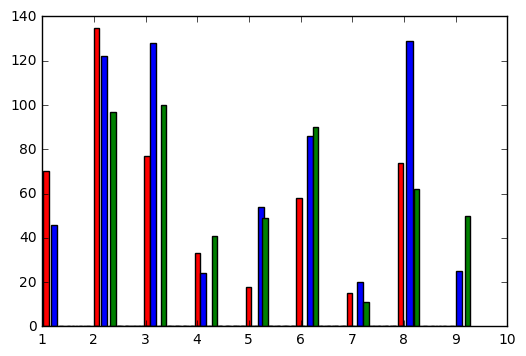

In [56]:
hist, bins = np.histogram(regime1B_test, bins=50)
width = 0.75 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width,color='red')

hist, bins = np.histogram(regime2B_test, bins=50)
width = 0.75 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2 +0.15
plt.bar(center, hist, align='center', width=width,color='blue')
hist, bins = np.histogram(regime3B_test, bins=50)
width = 0.75 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2 +0.3
plt.bar(center, hist, align='center', width=width,color='green')

plt.show()
